In [257]:
# Преоразовать существующий код для распознавания последовательности рукописных символов в текст.
# Написать генератор произвольной последовательности рукописных символов.

# ГЕНЕРАЦИЯ НАБОРА ДАННЫХ
# Сгенерировать набор текстовых строк из допустимых символов.
# Каждому набору поставить в соотвествие массив изоражений соответствующих символов.
# Добавить пробелы для разделения слов, символы пробелов не использовать во время классификации.

# КЛАССИФИКАЦИЯ (k ближайших соседей) (пример AIM practice 2)
# Часть символов оставить для обучения классификатора . Остальные  классифицировать
# по аналогии с примером mnist с прошлого занятия. Т.е. преобразовывать изображение в вектор.
# Выбрать оптимальный классификатор в зависимости от k- количество соседей.
# Метрика для измерения точности классификации, и выбора оптимального классификатора относительно параметра k - accuracy.

# РАСПОЗНАВАНИЕ
# заменить inf_net на последовательное применение следующих шагов:
# 1. генерация изображения с последовательностью символов
# 2. Выделение объектов оставляете как есть.
# 3. Примернить k-nn для решения задачи классификации. 
# 4. Вывести результат

import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

In [258]:
class IMAGE:
    HEIGHT = 45
    WIDTH = 45
PADDING = 0
SPASING = 40
DATA_FOLDER = "./data"
ALLOWED_SYMBOLS = list("-,()+0123456789ht*wxy")
SEQUENCE_LENGTH = 5  # пример длины последовательности
PERCENT_SAMPLES_PER_SYMBOL = 0.5  # число образцов для каждого символа
NAME_FOLDERS = [x[0].split('\\')[-1] for x in os.walk(DATA_FOLDER)]
NAME_FOLDERS = NAME_FOLDERS[1:]


# 1. Генерация изображения последовательности символов

Исходная последовательность: 17xx41h+8+


(np.float64(-0.5), np.float64(809.5), np.float64(44.5), np.float64(-0.5))

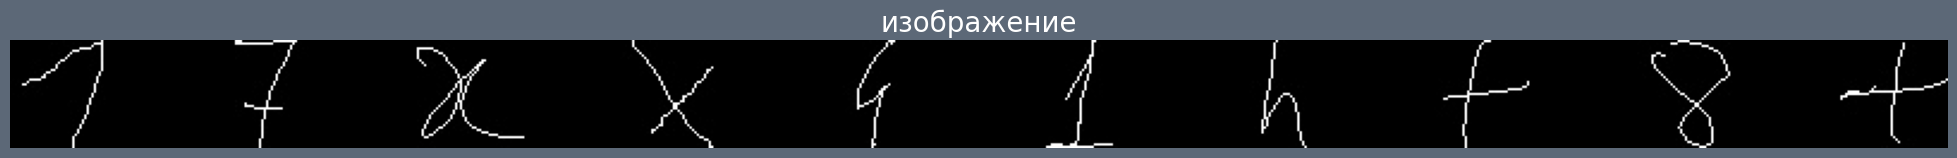

In [267]:
def getSymbol(char):
    img_name = char
    if (char == 'x'):
        img_name = 'X'
    if (char == '*'):
        img_name = 'times'
    symbol_dir = os.path.join(DATA_FOLDER, img_name)
    images = [image for image in os.listdir(symbol_dir)] 
    start_index = int(len(images) * PERCENT_SAMPLES_PER_SYMBOL)
    remaining_part = images[start_index:]
    random_image = random.choice(remaining_part)
    img_path = os.path.join(symbol_dir, random_image)
    return cv2.imread(img_path, cv2.IMREAD_GRAYSCALE).__invert__()


def makeText(length=6):
    string = ''.join(random.choices(ALLOWED_SYMBOLS, k=length))
    img_width = (IMAGE.WIDTH * length +
                 PADDING * 2 +
                 SPASING * (length - 1))
    img_height = IMAGE.HEIGHT + PADDING * 2
    string_img = np.zeros((img_height, img_width), dtype=np.uint8) * 255
    for i, symbol in enumerate(string):
        begin_x = PADDING+i*(IMAGE.WIDTH+SPASING)
        string_img[PADDING:PADDING+IMAGE.HEIGHT, begin_x:begin_x+IMAGE.WIDTH] = getSymbol(symbol)
    return string, string_img


str, img = makeText(10)
plt.figure(figsize=(25, 20), facecolor="#5c6877")
print(f'Исходная последовательность: {str}')
plt.title('изображение',color='white', fontsize=20)
plt.imshow(img, cmap='gray')
plt.axis('off')



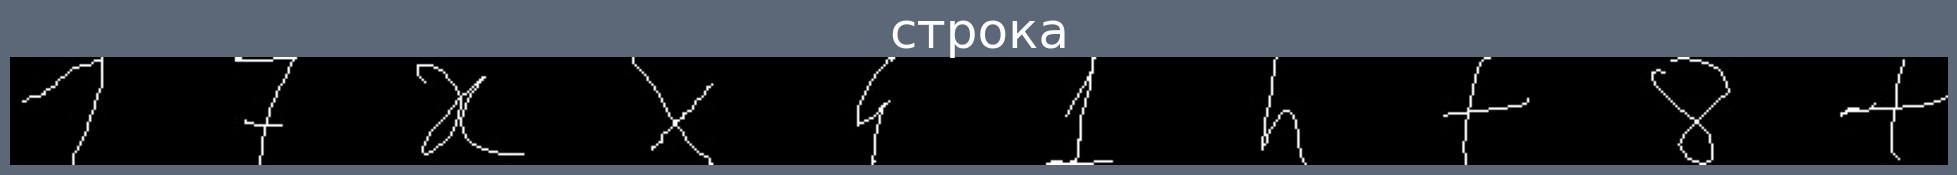

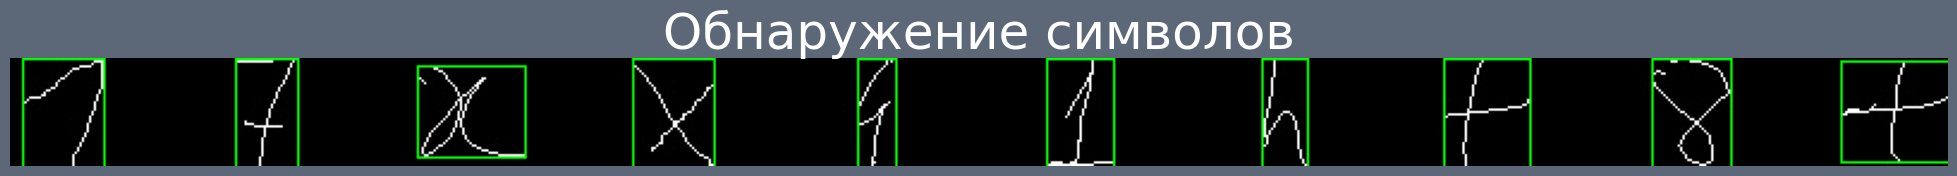

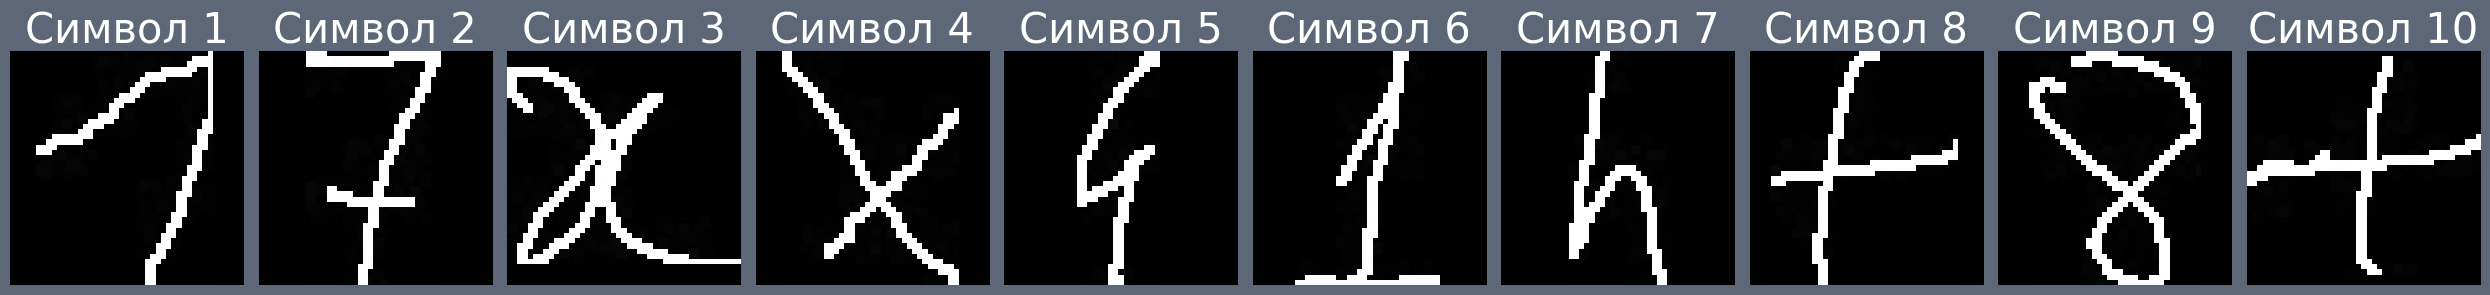

In [269]:
img_gray = img
kernel = np.ones((2,2),np.uint8)

plt.figure(figsize=(25, 5), facecolor="#5c6877")
plt.title('строка', color='white', fontsize=36)
plt.axis('off')
plt.imshow(cv2.cvtColor(img_gray, cv2.COLOR_BGR2RGB))
plt.show()

_, thresh = cv2.threshold(img_gray,127,255,0)
thresh = np.uint8(thresh)
contour_image = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2BGR)
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


borders = []
contours_sorted = sorted(contours, key=lambda cnt: cv2.boundingRect(cnt)[0])
for i in range(len(contours_sorted)):
    cnt = contours_sorted[i] 
    x,y,w,h = cv2.boundingRect(cnt)
    if w*h > 50:
        cv2.rectangle(contour_image, (x, y), (x+w, y+h), (0, 255, 0), 1)
        borders.append([x,y,w,h])

plt.figure(figsize=(25, 5), facecolor="#5c6877")
plt.title('Обнаружение символов', color='white', fontsize=36)
plt.axis('off')
plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
plt.show()


sequence_symbols = []

plt.figure(figsize=(25, 5), facecolor="#5c6877")
for i in range(len(borders)):
    x, y, w, h = borders[i]
    img_crop = img_gray[y:y+h, x:x+w]
    
    padded_img = np.ones((IMAGE.WIDTH, IMAGE.HEIGHT), dtype=np.uint8)
    
    x_offset = (IMAGE.WIDTH  - w) // 2
    y_offset = (IMAGE.HEIGHT - h) // 2
    padded_img[y_offset:y_offset+h, x_offset:x_offset+w] = cv2.dilate(img_crop,kernel,iterations = 1) # img_crop
    
    base = padded_img.copy()
    sequence_symbols.append((x, base))
    
    plt.subplot(1, len(borders), i+1)
    plt.title(f'Символ {i+1}', color='white', fontsize=30)
    plt.axis('off')
    plt.imshow(base, cmap="gray")
    plt.tight_layout()

plt.show()



all_data_img = {
    'string': str,
    'images_of_symbols': sequence_symbols
}

In [270]:
def load_training_data(data_path, symbols, train_ratio=0.5):
    X_train, y_train = [], []

    for symbol in symbols:
        symbol_path = os.path.join(data_path, symbol)
        if not os.path.exists(symbol_path):
            continue  # пропуск, если папка отсутствует

        images = [f for f in os.listdir(symbol_path) if os.path.isfile(os.path.join(symbol_path, f))]
        images.sort()

        split_index = int(len(images) * train_ratio)
        train_images = images[:split_index]

        for img_name in train_images:
            img_path = os.path.join(symbol_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue  # пропускаем, если изображение не удалось загрузить
            
            X_train.append(img.flatten())

            # Обработка специальных символов
            symbol_label = symbol
            if symbol_label == 'X':
                symbol_label = 'x'
            elif symbol_label == 'times':
                symbol_label = '*'
            y_train.append(symbol_label)

    return np.array(X_train), np.array(y_train)

In [271]:
# name_folders = ['0','1','2','3','4','5','6','7','8','9','+','-','times','t','X','y','w','h','(',')',',']
X_train, y_train = load_training_data(DATA_FOLDER, NAME_FOLDERS, 0.5)
print(f"Обучающая выборка: {len(X_train)} изображений")

Обучающая выборка: 125902 изображений


In [272]:
knn1 = KNeighborsClassifier(n_neighbors=1)
knn3 = KNeighborsClassifier(n_neighbors=3)
knn5 = KNeighborsClassifier(n_neighbors=5)
knn7 = KNeighborsClassifier(n_neighbors=7)

knn1.fit(X_train, y_train)
print("Модель k = 1 успешно обучена!")
knn3.fit(X_train, y_train)
print("Модель k = 3 успешно обучена!")
knn5.fit(X_train, y_train)
print("Модель k = 5 успешно обучена!")
knn7.fit(X_train, y_train)
print("Модель k = 7 успешно обучена!")

Модель k = 1 успешно обучена!
Модель k = 3 успешно обучена!
Модель k = 5 успешно обучена!
Модель k = 7 успешно обучена!


In [273]:
def predict_symbol(model, image):
    image = cv2.bitwise_not(image)
    img_flat = image.flatten()
    prediction = model.predict([img_flat])
    return prediction[0]

Исходная последовательность: 17xx41h+8+


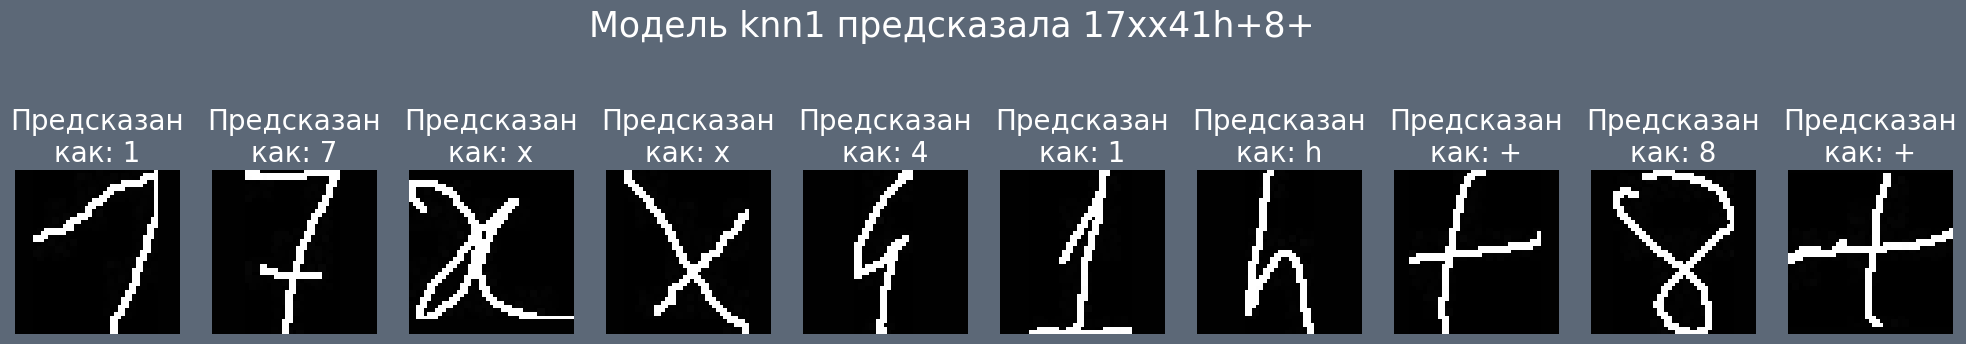


Статистика для модели knn1:
              precision    recall  f1-score   support

           h       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         2
           +       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         1
           x       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         1

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



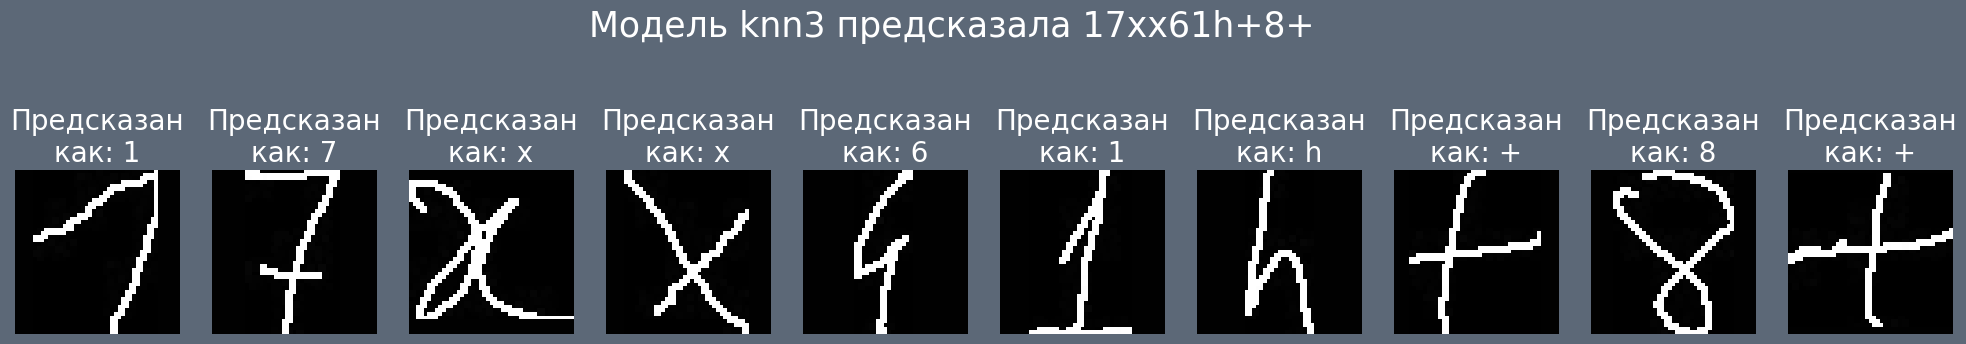


Статистика для модели knn3:
              precision    recall  f1-score   support

           h       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         2
           +       1.00      1.00      1.00         2
           4       1.00      0.00      0.00         1
           x       1.00      1.00      1.00         2
           6       0.00      1.00      0.00         0
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         1

    accuracy                           0.90        10
   macro avg       0.88      0.88      0.75        10
weighted avg       1.00      0.90      0.90        10



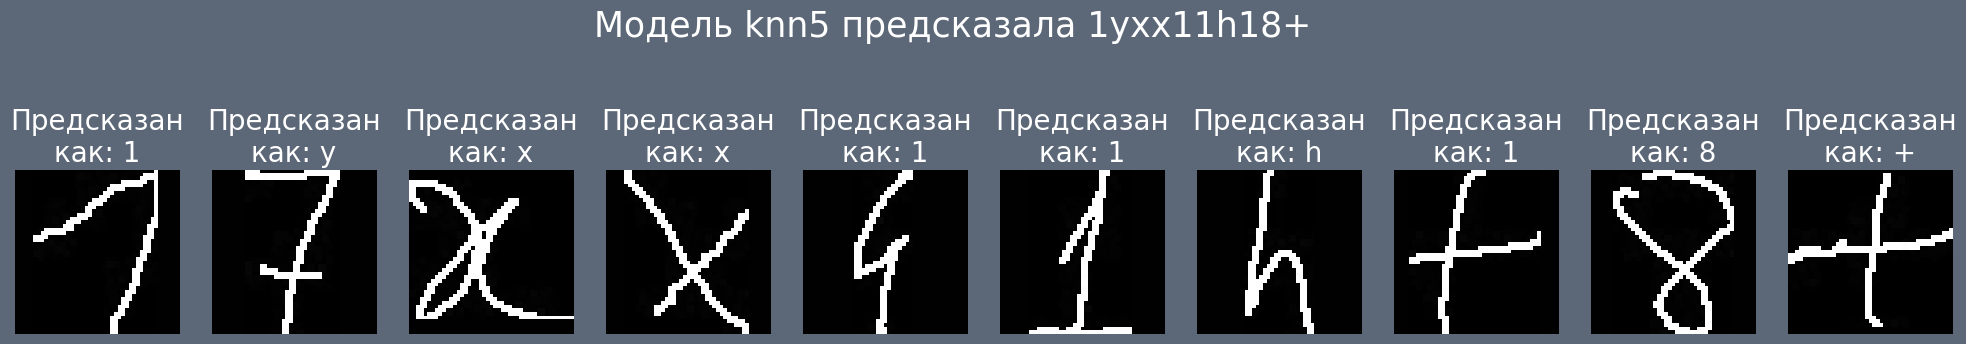


Статистика для модели knn5:
              precision    recall  f1-score   support

           h       1.00      1.00      1.00         1
           1       0.50      1.00      0.67         2
           +       1.00      0.50      0.67         2
           y       0.00      1.00      0.00         0
           4       1.00      0.00      0.00         1
           x       1.00      1.00      1.00         2
           7       1.00      0.00      0.00         1
           8       1.00      1.00      1.00         1

    accuracy                           0.70        10
   macro avg       0.81      0.69      0.54        10
weighted avg       0.90      0.70      0.67        10



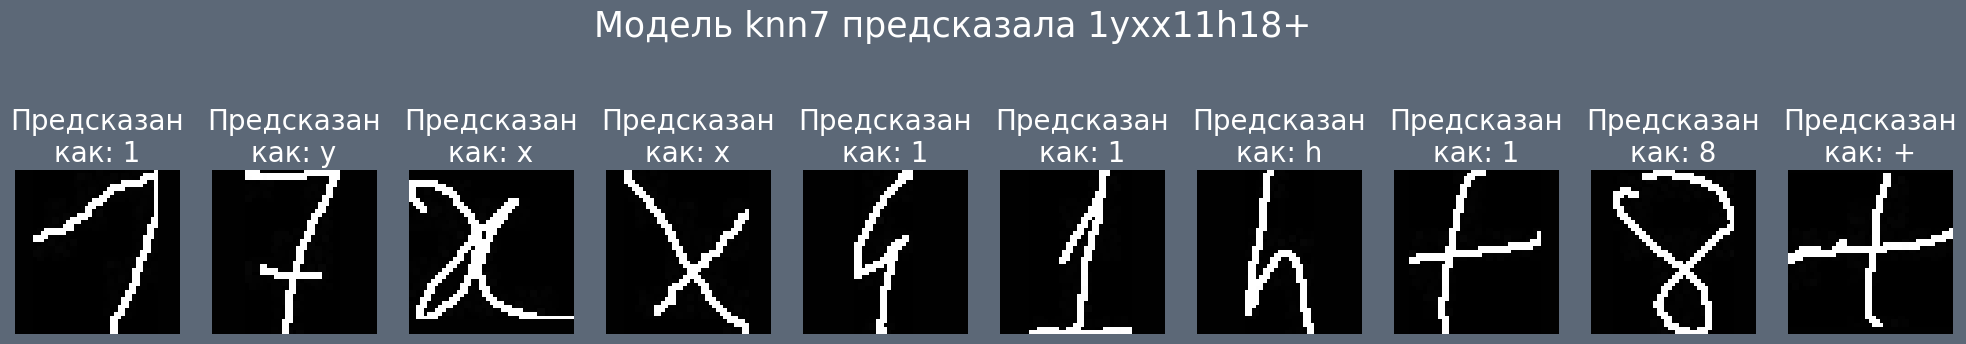


Статистика для модели knn7:
              precision    recall  f1-score   support

           h       1.00      1.00      1.00         1
           1       0.50      1.00      0.67         2
           +       1.00      0.50      0.67         2
           y       0.00      1.00      0.00         0
           4       1.00      0.00      0.00         1
           x       1.00      1.00      1.00         2
           7       1.00      0.00      0.00         1
           8       1.00      1.00      1.00         1

    accuracy                           0.70        10
   macro avg       0.81      0.69      0.54        10
weighted avg       0.90      0.70      0.67        10

Отчет по все моделям
knn1 --- Accuracy = 1.00 --- predicted text = 17xx41h+8+

knn3 --- Accuracy = 0.90 --- predicted text = 17xx61h+8+

knn5 --- Accuracy = 0.70 --- predicted text = 1yxx11h18+

knn7 --- Accuracy = 0.70 --- predicted text = 1yxx11h18+



In [275]:
original_text = all_data_img['string']
symbols_data = all_data_img['images_of_symbols']
print(f"Исходная последовательность: {original_text}")

models = {
    'knn1': knn1,
    'knn3': knn3, 
    'knn5': knn5,
    'knn7': knn7
}
results = []

for model_name, model in models.items():
    predicted_symbols = []
    plt.figure(figsize=(25, 5), facecolor="#5c6877")
    for j, (x, symbol_img) in enumerate(symbols_data):
        predicted_char = predict_symbol(model, symbol_img)
        predicted_symbols.append(predicted_char)
        plt.subplot(1, len(symbols_data), j+1)
        plt.imshow(symbol_img, cmap='gray')
        plt.title(f'Предсказан\nкак: {predicted_char}',color='white', fontsize=20)
        plt.axis('off')
    predicted_text = ''.join(predicted_symbols)
    plt.suptitle(f'Модель {model_name} предсказала {predicted_text}', color='white', fontsize=25)
    plt.show()

    y_true = list(original_text)
    y_pred = list(predicted_text)
    all_symbols = list(set(original_text) | set(predicted_text))
    
    report_dict = classification_report(y_true, y_pred, labels=all_symbols, zero_division=1, output_dict=True)    
    accuracy = report_dict['accuracy']

    results.append([accuracy, predicted_text])
    print(f"\nСтатистика для модели {model_name}:")
    print(classification_report(y_true, y_pred, labels=all_symbols, zero_division=1))


print('Отчет по все моделям')
for i, (model_name) in enumerate(models):
    print(f'{model_name} --- Accuracy = {results[i][0]:.2f} --- predicted text = {results[i][1]}\n')